In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
def read_and_clean(filename):
    '''
    Function takes input as filename to be cleaned. Rows that have values of nan are deleted. 
    Remaining rows are returned as an ndarray.
    '''
    data = np.genfromtxt(fname)
    data = np.delete(data, np.where(np.isnan(data))[0], axis=0)
    
    return data

<i>Using the convolve function was not an original idea - I would like to thank Stackoverflow for this.</i>

In [3]:
def smooth_data(data, width):
    '''
    This function takes the rolling/moving average of the fluxes - second column of the 'data' array
    This is done by using the numpy.convolve method. 
    '''
    return np.convolve(data[:,1], np.ones(width), 'valid')/width # This returns along with the 'side' 
                                                                 # values for now - these are to be exluded later
    

In [4]:
def plot_light_curve(data):
    plt.plot(data[:,0], data[:,1], ',')


In [5]:
def find_freq(data, max_freq = 2000, n_bins = 100):
    freq_range = np.linspace(.2, max_freq, n_bins)
    power = sc.signal.lombscargle(data[:,0], data[:,1], freq_range, normalize = True)
    # plt.plot(freq_range, power)
    T_peak = 1/freq_range[np.argmax(power)] # Identifying peak of power function and returning corresponding time period

    fig_fft, ax3 = plt.subplots(1, 1, figsize=(12,5), facecolor='aliceblue')
    ax3.plot(freq_range, power)
    return T_peak, power

<i>The above function seems to produce varying results for different values of n_bins, which should not be happening.</i>

In [6]:
def eclipse(time, t_0,t_total, t_in, d, f_star):
    '''
    t_0 is the point in time that corresponds to the start of the eclipse.
    t_total is the commplete duration of the eclipse
    t_in is the ingress time of the eclipse (egress time is assumed to equal ingress time.
    d is the depth of the eclipse
    '''
    slope = d/t_in
    print(slope)
    # If t < t_0 or if t>t_0, f = f_star
    # If t > t_0 and t < t_0 + t_in, f = straight line
    # if t > t_0 + t_in and t < t_0 + t_total - t_in, f = f_star-d
    # If t > t_0 + t_total - t_in and t < t_0 + t_total, f = straight line with opp slope
    # If t > t_0 + t_total, f = f_star
    temp = np.where((time<t_0) | (time > t_0 + t_total), f_star, f_star-1000)
    temp = np.where((time >= t_0) & (time < t_0 + t_in), f_star - slope*(time-t_0), temp)
    temp = np.where((time > t_0 + t_in) & (time < t_0 + t_total - t_in), f_star - d, temp)
    temp = np.where((time > t_0 + t_total - t_in) & (time < t_0 + t_total), f_star -slope*(t_0 + t_total-time), temp)
    # temp = np.where((time > t_0 + t_total - t_in) & (time < t_0 + t_total), f_star - 400, temp)
    print(temp)
    
    return temp

Time period = 2.875722543352601 days
40000.0
[135900. 135900. 135900. ... 135900. 135900. 135900.]
40000.0
[135900. 135900. 135900. ... 135900. 135900. 135900.]
40000.0
[135900. 135900. 135900. ... 135900. 135900. 135900.]
39999.99940395356
[135900. 135900. 135900. ... 135900. 135900. 135900.]
40000.00059604645
[135900. 135900. 135900. ... 135900. 135900. 135900.]
40000.0
[135900.00202507 135900.00202507 135900.00202507 ... 135900.00202507
 135900.00202507 135900.00202507]
22322.849956221497
[135907.22535442 135907.22535442 135907.22535442 ... 135907.22535442
 135907.22535442 135907.22535442]
22322.849956221497
[135907.22535442 135907.22535442 135907.22535442 ... 135907.22535442
 135907.22535442 135907.22535442]
22322.849956221497
[135907.22535442 135907.22535442 135907.22535442 ... 135907.22535442
 135907.22535442 135907.22535442]
22322.84962358512
[135907.22535442 135907.22535442 135907.22535442 ... 135907.22535442
 135907.22535442 135907.22535442]
22322.850288857884
[135907.22535442

ValueError: operands could not be broadcast together with shapes (1365,) (5,) 

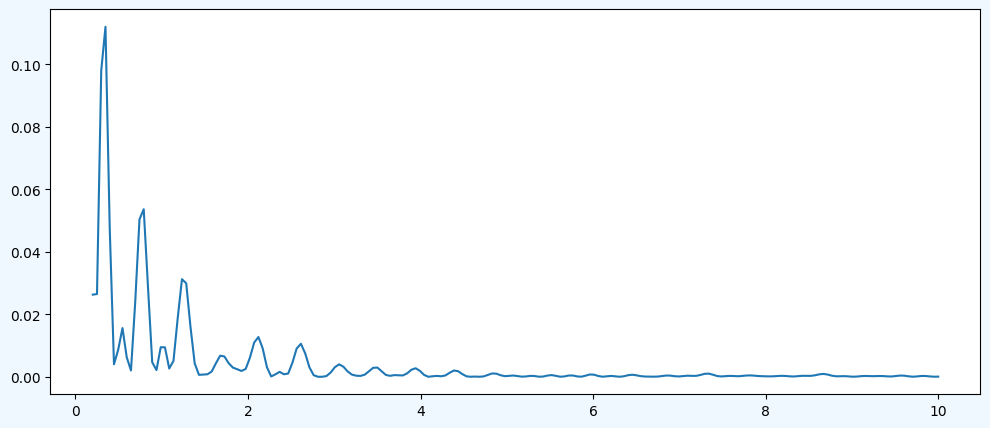

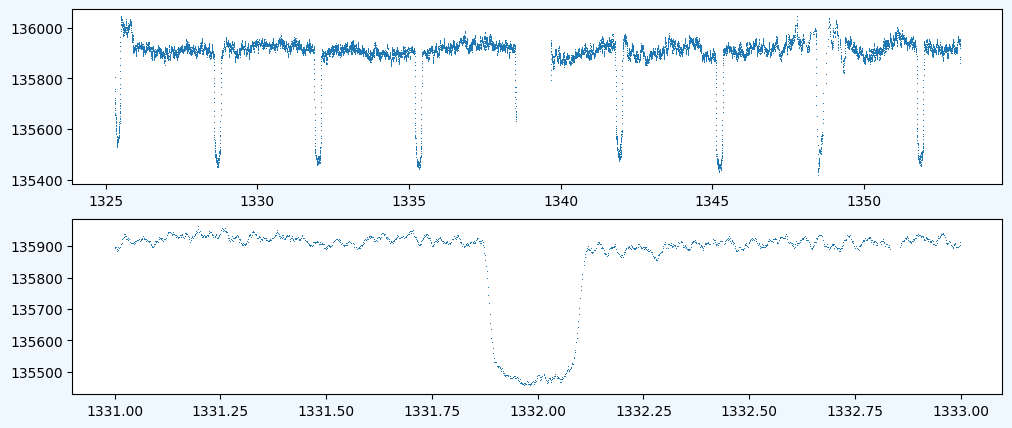

In [7]:
fname = 'Data/tess_lc1.dat'
window_length = 13  # has to be odd as you need to take the same number of values on either side of the cell
dat = read_and_clean(fname)

dat[:,1][int((window_length-1)/2):-int((window_length-1)/2)] = smooth_data(dat,window_length)
# plt.plot(dat[:,0], dat[:,1], ',')
# plt.show()
print(f'Time period = {find_freq(dat, 10, 200)[0]} days')
selected_data = dat[np.logical_and(dat[:,0] > 1331, dat[:,0] < 1333)]

fig_timeseries, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5), facecolor='aliceblue')
ax1.plot(dat[:,0], dat[:,1], ',')
ax2.plot(selected_data[:,0], selected_data[:,1], ',', label='Data')

# dat[:,0] = np.loc(np.where((dat[:,0] < 1331), True, dat[:,0]))
# selector = [np.logical_and(dat[:,0] > 1331, dat[:,0] < 1333)]


# selected_data[:,1] = eclipse(selected_data[:,0],t_0 = 1331.9, t_total = 0.2, t_in = .01, d = 400, f_star = 135900) 
# print(selected_data)

results = sc.optimize.curve_fit(eclipse, selected_data[:,0], selected_data[:,1], [1331.9, 0.2, .01, 400, 135900])
# print('results', results)
selected_data[:,1] = eclipse(selected_data[:,0], results[-1][0], results[-1][1],results[-1][2], results[-1][3], results[-1][4])
ax2.plot(selected_data[:,0], selected_data[:,1], label='Model')
ax2.legend()
plt.show()
